In [1]:
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from keras import backend as K
from keras.layers import Dense, Activation, Input, concatenate,Lambda,GaussianNoise
from keras.models import Model, load_model
from keras.optimizers import Adam
from IPython.display import clear_output

from warnings import filterwarnings
filterwarnings('ignore')


import seaborn as sns
sns.set_context("paper")
sns.set_style("darkgrid")

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Using TensorFlow backend.


In [2]:
env=gym.make("Pendulum-v0")
env.reset()
state_dim = env.observation_space.shape
lower_bound_action,upper_bound_action=env.action_space.low,env.action_space.high
n_actions = lower_bound_action.shape[0]

In [3]:
class DDPG(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        self.gamma=0.99999
        
        self.actor=self.Actor(paras)
        self.target_actor=self.Actor(paras)
        self.target_actor.set_weights(self.actor.get_weights())
        
        self.critic=self.Critic(paras)
        self.target_critic=self.Critic(paras,Target=True)
        self.target_critic.set_weights(self.critic.get_weights())
        
        self.sigma=self.upper_bound_action-self.lower_bound_action
        self.memory=[]
        self.memory_size=paras['memory_size']
        self.batch_size=paras['batch_size']
        self.update_freq=paras['update_freq']
        self.sigma_decay=paras['sigma_decay'] 
        self.tau=paras['polyak']
        self.count=0
        self.pure_explore_step=paras['pure_explore_step']
        self.start_learning_step=paras['start_learning_step']
        
    def Actor(self,paras):
        state = Input(shape=[self.dim_state,])
        for idx,layer in enumerate(agent_config['structure_actor']):
            if idx==0:
                dense_layers = [GaussianNoise(1.0)(Dense(layer, activation='relu')(state))]
            else:
                dense_layers.append(GaussianNoise(1.0)(Dense(layer, activation='relu')(dense_layers[-1])))
        mu = Dense(self.num_action, activation='tanh')(dense_layers[-1])
        mu = Lambda(lambda i: i * self.upper_bound_action)(mu)
        
        actor = Model(inputs=[state], outputs=[mu])
        actor.compile(optimizer=Adam(lr=agent_config['alpha_actor']), loss="mse")
        return actor
    
        
    def Critic(self,paras,Target=False):
        state = Input(shape=[self.dim_state,])
        action = Input(shape=[self.num_action,])
        combined = concatenate([state, action])
        for idx,layer in enumerate(agent_config['structure_critic']):
            if idx==0:
                dense_layers = [GaussianNoise(1.0)(Dense(layer, activation='relu')(combined))]
            else:
                dense_layers.append(GaussianNoise(1.0)(Dense(layer, activation='relu')(dense_layers[-1])))
        value = Dense(1, activation='linear')(dense_layers[-1])
        Q_s_a = Model(inputs=[state,action], outputs=[value])
        Q_s_a.compile(optimizer=Adam(lr=agent_config['alpha_critic']), loss="mse")
        
        if not Target:
            gradient = K.gradients(Q_s_a.output, Q_s_a.input)[1]
            self.get_grad = K.function(Q_s_a.input, [gradient])
        return Q_s_a

    def memorize(self,s,a,r,sp,done):
        self.memory.append([s,a,r,sp,done])
        if len(self.memory)>self.memory_size:
            del self.memory[0] 
    
    def sample_exp(self):
        index_set=np.random.choice(range(len(self.memory)),
                    size=min(len(self.memory),self.batch_size),replace=False)
        return np.array(self.memory)[index_set]
     
    def learn(self):        
        self.count+=1
        if self.count%self.update_freq==0 and len(self.memory)>=self.start_learning_step:
            sampled_exp=self.sample_exp()
            s=np.array([list(_) for _ in sampled_exp[:,0]])
            a=np.array([list(_) for _ in sampled_exp[:,1]])
            r=sampled_exp[:,2].reshape(-1,1)
            sp=np.array([list(_) for _ in sampled_exp[:,3]])
            done=sampled_exp[:,4].reshape(-1,1)
            self.update_paras(s,a,r,sp,done)
            if len(self.memory)>=self.pure_explore_step:
                self.sigma*=self.sigma_decay 
                self.sigma[self.sigma<=1e-5]=1e-5
    
    def get_actions(self,s,train=True):
        if len(self.memory)<=self.pure_explore_step and train:
            a=np.random.random(size=(1,self.num_action))*(self.upper_bound_action-self.lower_bound_action)
        elif train:
            sigma=self.sigma
            mu=self.actor.predict(s)
            a=mu+np.random.normal(np.zeros(self.num_action),sigma)  
            a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        else:
            a=self.actor.predict(s)
        return a 
    
    def update_paras(self,s,a,r,sp,done):
        mup=self.target_actor.predict(sp)
        Q_sp_ap=self.target_critic.predict([sp,mup])
        target=r+self.gamma*Q_sp_ap*(1-done)
        self.critic.fit([s,a],target,verbose=False) 
        
        
        mu=self.actor.predict(s)
        d_mu=self.get_grad([s,mu])[0]
        self.actor.fit(s,mu+d_mu,verbose=False) 
        
        old_weight_target_critic=self.target_critic.get_weights()
        weight_critic=self.critic.get_weights()
        new_weight_target_critic=[(1-self.tau)*weight_critic[idx]+self.tau*old_weight_target_critic[idx] for idx in range(len(weight_critic))]
        
        old_weight_target_actor=self.target_actor.get_weights()
        weight_actor=self.actor.get_weights()
        new_weight_target_actor=[(1-self.tau)*weight_actor[idx]+self.tau*old_weight_target_actor[idx] for idx in range(len(weight_actor))]
        
        self.target_critic.set_weights(new_weight_target_critic)
        self.target_actor.set_weights(new_weight_target_actor)
        

1 -1502.146670767438 [4.] 200
2 -1294.4243461876213 [4.] 400
3 -1526.9948660228522 [4.] 600
4 -1149.0546864002933 [4.] 800
5 -1183.4546596019234 [4.] 1000
6 -1335.0967618951445 [4.] 1200
7 -1254.1946705903354 [4.] 1400
8 -1183.6042096179276 [4.] 1600
9 -1505.4615077577084 [4.] 1800
10 -1489.6380788143115 [4.] 2000
10 -1342.4070457655557


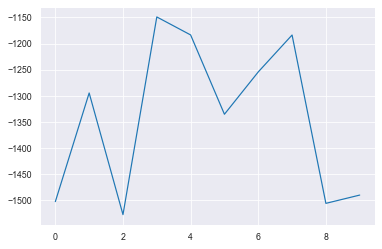

11 -1313.5015982999062 [4.] 2200
12 -1410.517335801037 [4.] 2400
13 -1498.2724971808248 [4.] 2600
14 -1103.8658109407907 [4.] 2800
15 -1348.8180744651593 [4.] 3000
16 -1529.972173418131 [4.] 3200
17 -1376.8427171981195 [4.] 3400
18 -1397.4723575756943 [4.] 3600
19 -1303.283199808612 [4.] 3800
20 -1334.7944350527853 [4.] 4000
20 -1352.070532869831


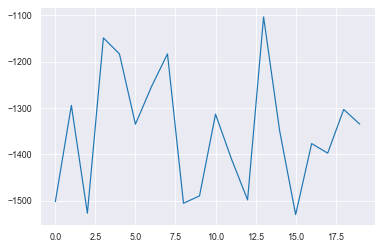

21 -1436.5900895565453 [4.] 4200
22 -1344.962595998919 [4.] 4400
23 -1254.237056802141 [4.] 4600
24 -1416.3443558811903 [4.] 4800
25 -1427.2766831315691 [4.] 5000
26 -1518.1119992237423 [4.] 5200
27 -1508.5048793240594 [4.] 5400
28 -1508.426454100477 [4.] 5600
29 -1624.8676140581206 [4.] 5800
30 -1427.185653153379 [4.] 6000
30 -1383.5972679542251


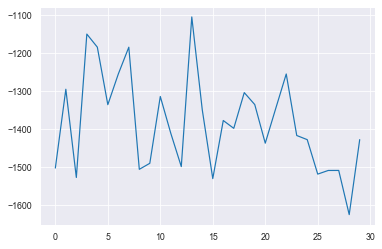

31 -1495.640028203781 [4.] 6200
32 -1095.7161314208392 [4.] 6400
33 -1506.8039333787303 [4.] 6600
34 -1152.368093696459 [4.] 6800
35 -1177.4617197318976 [4.] 7000
36 -1187.3478006770533 [4.] 7200
37 -1534.12107433961 [4.] 7400
38 -1371.684644301066 [4.] 7600
39 -1458.7745723212072 [4.] 7800
40 -1515.2557585439815 [4.] 8000
40 -1375.0772948810347


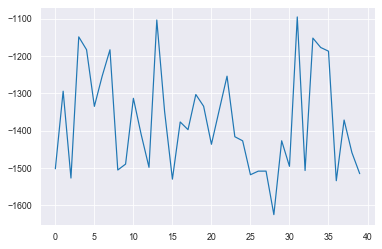

41 -1507.0623113576207 [4.] 8200
42 -1338.8889055510851 [4.] 8400
43 -1520.2950644260798 [4.] 8600
44 -1525.040760700817 [4.] 8800
45 -1536.125068666845 [4.] 9000
46 -1049.8885460116894 [4.] 9200
47 -1408.7066912028615 [4.] 9400
48 -1507.4615468779114 [4.] 9600
49 -1475.510586605208 [4.] 9800
50 -1471.723044391556 [3.996] 10000
50 -1386.8758864206611


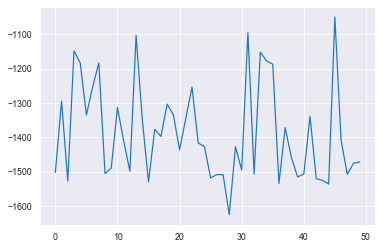

51 -1171.0882341718643 [3.2713287] 10200
52 -1118.9594248828448 [2.6780767] 10400
53 -1259.2674471717082 [2.1924098] 10600
54 -1445.5962308241474 [1.7948194] 10800
55 -1553.2753619347504 [1.4693302] 11000
56 -1272.3047429990836 [1.202869] 11200
57 -1583.133308837543 [0.98472947] 11400
58 -1115.6552742413219 [0.80614966] 11600
59 -1111.8128572012827 [0.65995526] 11800
60 -1528.6799832109948 [0.5402731] 12000
60 -1381.5899345770606


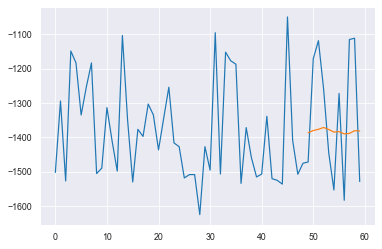

61 -1552.730620559967 [0.44229522] 12200
62 -1078.161766999837 [0.36208537] 12400
63 -949.541726589632 [0.29642162] 12600
64 -1065.4925596402168 [0.24266596] 12800
65 -1165.9638192499397 [0.19865876] 13000
66 -1512.8740277812706 [0.1626322] 13200
67 -1426.4162245228658 [0.13313898] 13400
68 -1532.1963851644675 [0.1089944] 13600
69 -1500.3423263740701 [0.08922836] 13800
70 -1503.8370404794982 [0.07304686] 14000
70 -1374.994260529475


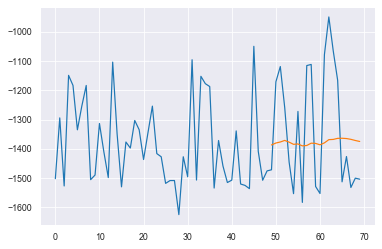

71 -1613.7476644290248 [0.05979986] 14200
72 -1624.5544364119166 [0.04895522] 14400
73 -1473.8619170768714 [0.04007723] 14600
74 -1502.09717324432 [0.03280927] 14800
75 -1050.134025199737 [0.02685933] 15000
76 -1169.0845911077047 [0.02198842] 15200
77 -1452.908105826227 [0.01800085] 15400
78 -939.3860388612285 [0.01473642] 15600
79 -1365.6355891892101 [0.01206399] 15800
80 -1178.3034313302724 [0.0098762] 16000
80 -1353.0583723584027


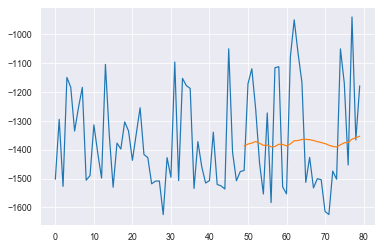

81 -950.2293592786747 [0.00808515] 16200
82 -1396.676905239437 [0.00661892] 16400
83 -1301.668135001699 [0.00541858] 16600
84 -1204.8340895618444 [0.00443593] 16800
85 -1563.0530126910817 [0.00363148] 17000
86 -1077.1107047450537 [0.00297291] 17200
87 -1234.9214244169145 [0.00243378] 17400
88 -1004.3267739210738 [0.00199241] 17600
89 -1616.2506964947922 [0.00163109] 17800
90 -1643.6084972996857 [0.00133529] 18000
90 -1343.0084891991148


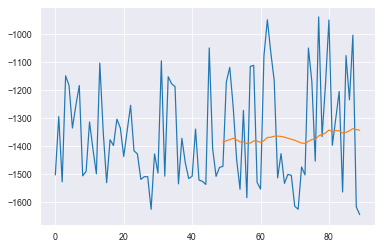

91 -1612.4602376341472 [0.00109314] 18200
92 -1654.1662361026733 [0.0008949] 18400
93 -1589.6071899439416 [0.00073261] 18600
94 -1559.8057868822805 [0.00059975] 18800
95 -1543.5176353658583 [0.00049099] 19000
96 -1654.6382242066081 [0.00040195] 19200
97 -1637.150767348955 [0.00032905] 19400
98 -1598.358134654627 [0.00026938] 19600
99 -1653.2166104850717 [0.00022053] 19800
100 -1606.3052414429258 [0.00018054] 20000
100 -1378.3789599646234


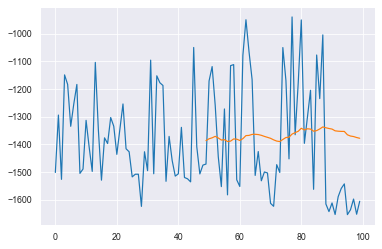

101 -1654.192251478445 [0.0001478] 20200
102 -1648.3985796858626 [0.00012099] 20400
103 -1656.363274798136 [9.905144e-05] 20600
104 -1603.1778404434797 [8.1088576e-05] 20800
105 -1631.456260564473 [6.638322e-05] 21000
106 -1655.613607749441 [5.434466e-05] 21200
107 -1652.7717908483964 [4.448929e-05] 21400
108 -1560.0586770956672 [3.642119e-05] 21600
109 -1483.1735583943896 [2.981625e-05] 21800
110 -1640.941856759556 [2.4409093e-05] 22000
110 -1438.9064566114694


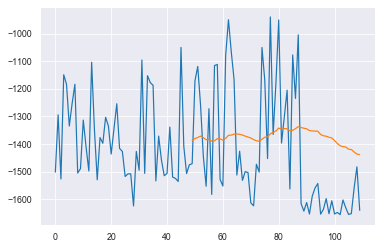

111 -1648.6187008478767 [1.9982537e-05] 22200
112 -1580.5660070890258 [1.6358732e-05] 22400
113 -1642.3212131153275 [1.3392086e-05] 22600
114 -1605.6945830839848 [1.0963444e-05] 22800
115 -1582.7215821542773 [1.e-05] 23000
116 -1639.6882592017357 [1.e-05] 23200
117 -1613.6296994997708 [1.e-05] 23400
118 -1587.712828649874 [1.e-05] 23600
119 -1575.0702656061537 [1.e-05] 23800
120 -1643.960376824025 [1.e-05] 24000
120 -1495.554996985675


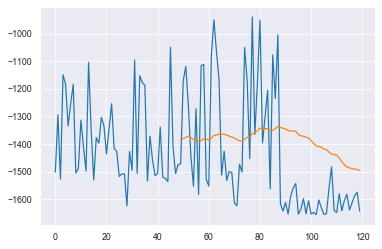

121 -1520.1558100572604 [1.e-05] 24200
122 -1498.1328160276232 [1.e-05] 24400
123 -1494.2359063840731 [1.e-05] 24600
124 -1642.446123506835 [1.e-05] 24800
125 -1497.0919898386462 [1.e-05] 25000
126 -1647.4471778675263 [1.e-05] 25200
127 -1192.5551991147472 [1.e-05] 25400
128 -1653.4861556039286 [1.e-05] 25600
129 -1653.032026659041 [1.e-05] 25800
130 -1458.6027835903076 [1.e-05] 26000
130 -1533.3044573051448


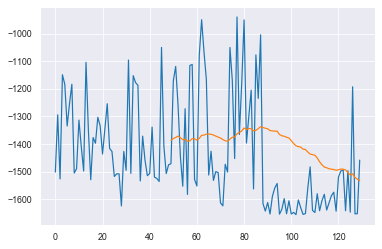

131 -1450.6308236893292 [1.e-05] 26200
132 -1521.5570979721338 [1.e-05] 26400
133 -1621.5530759386188 [1.e-05] 26600
134 -1648.3563788390525 [1.e-05] 26800
135 -1566.8564699923722 [1.e-05] 27000
136 -1175.7137256312096 [1.e-05] 27200
137 -1639.235625979659 [1.e-05] 27400
138 -1126.6174802640926 [1.e-05] 27600
139 -1494.321373704558 [1.e-05] 27800
140 -947.177590724601 [1.e-05] 28000
140 -1557.2912581868522


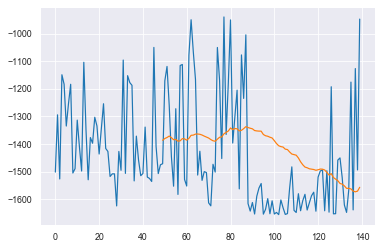

141 -1331.9502410284017 [1.e-05] 28200
142 -1637.2893272998688 [1.e-05] 28400
143 -1647.573462911424 [1.e-05] 28600
144 -1403.7743727627687 [1.e-05] 28800
145 -1647.3468616710518 [1.e-05] 29000
146 -1637.8730485862307 [1.e-05] 29200
147 -717.0509388707507 [1.e-05] 29400
148 -1075.3053307204023 [1.e-05] 29600
149 -1175.3272957409558 [1.e-05] 29800
150 -1643.658647734989 [1.e-05] 30000
150 -1513.449727452047


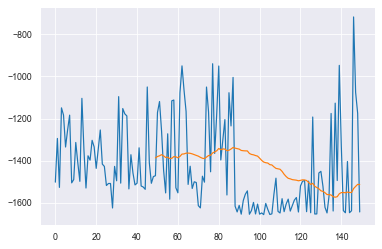

151 -1585.0786730025795 [1.e-05] 30200
152 -1297.1627384252583 [1.e-05] 30400
153 -1642.4758676791137 [1.e-05] 30600
154 -1507.7283456424773 [1.e-05] 30800
155 -1214.7999120659708 [1.e-05] 31000
156 -1287.4974986649393 [1.e-05] 31200
157 -1612.039285993755 [1.e-05] 31400
158 -1192.0579586965011 [1.e-05] 31600
159 -1500.371319927341 [1.e-05] 31800
160 -1657.4364414655315 [1.e-05] 32000
160 -1479.6597343269596


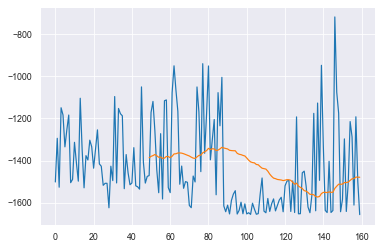

161 -1500.7644005921163 [1.e-05] 32200
162 -849.7750483669464 [1.e-05] 32400
163 -1186.2275940633394 [1.e-05] 32600
164 -943.2549682286559 [1.e-05] 32800
165 -1494.2145343379325 [1.e-05] 33000
166 -1653.2639749685611 [1.e-05] 33200
167 -1621.5650436027659 [1.e-05] 33400
168 -1630.7032393712939 [1.e-05] 33600
169 -1576.1894884652754 [1.e-05] 33800
170 -1065.2778547867697 [1.e-05] 34000
170 -1427.6847869411913


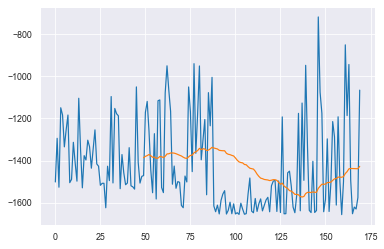

171 -949.7794061184746 [1.e-05] 34200
172 -1648.2793296915884 [1.e-05] 34400
173 -1579.4664314441757 [1.e-05] 34600
174 -974.550609285412 [1.e-05] 34800
175 -1645.4535529012817 [1.e-05] 35000
176 -1068.5674616325882 [1.e-05] 35200
177 -1629.2445210458948 [1.e-05] 35400
178 -1514.3428970372383 [1.e-05] 35600
179 -1577.1766210836497 [1.e-05] 35800
180 -1470.079104539921 [1.e-05] 36000
180 -1403.6798658637965


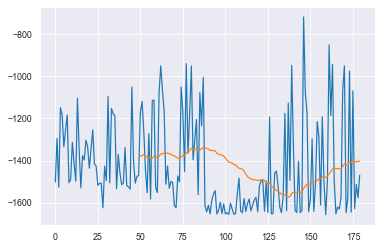

181 -761.9677877861301 [1.e-05] 36200
182 -1487.1576565093085 [1.e-05] 36400
183 -1314.0897742152408 [1.e-05] 36600
184 -1297.0763027022506 [1.e-05] 36800
185 -1024.4254286846965 [1.e-05] 37000
186 -1499.5435929620398 [1.e-05] 37200
187 -1372.8117546450887 [1.e-05] 37400
188 -727.5176750536536 [1.e-05] 37600
189 -1642.9512923672328 [1.e-05] 37800
190 -1657.7980376752923 [1.e-05] 38000
190 -1375.5462590611028


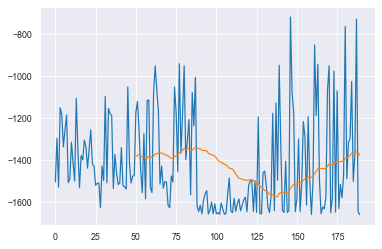

191 -1653.789656401021 [1.e-05] 38200
192 -785.1391328752779 [1.e-05] 38400
193 -752.3341500359279 [1.e-05] 38600
194 -1570.4969908956018 [1.e-05] 38800
195 -1470.8480959067379 [1.e-05] 39000
196 -1556.7918446013232 [1.e-05] 39200
197 -1627.193703233757 [1.e-05] 39400
198 -1462.68789973416 [1.e-05] 39600
199 -1607.424745678966 [1.e-05] 39800
200 -1575.5810308616583 [1.e-05] 40000
200 -1378.4490135190542


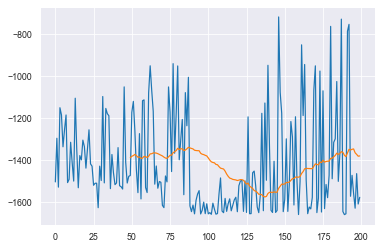

201 -1139.515069199837 [1.e-05] 40200
202 -1644.9323339352354 [1.e-05] 40400
203 -918.1430188338915 [1.e-05] 40600
204 -808.5167574685432 [1.e-05] 40800
205 -1652.465588492245 [1.e-05] 41000
206 -1641.4565520825038 [1.e-05] 41200
207 -1181.6852943523934 [1.e-05] 41400
208 -1566.6649530371187 [1.e-05] 41600
209 -638.3167002172598 [1.e-05] 41800
210 -1579.8451421200214 [1.e-05] 42000
210 -1343.9468808825657


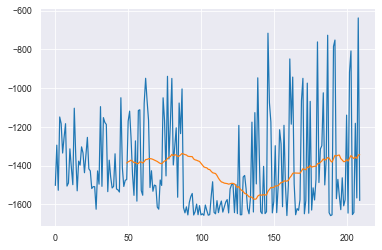

211 -1528.9400010315533 [1.e-05] 42200
212 -747.7765453498182 [1.e-05] 42400
213 -882.7014523711939 [1.e-05] 42600
214 -967.474289011619 [1.e-05] 42800
215 -1372.0966207370739 [1.e-05] 43000
216 -738.9960223065658 [1.e-05] 43200
217 -757.2153121805572 [1.e-05] 43400
218 -722.1260142862025 [1.e-05] 43600
219 -865.4096253050365 [1.e-05] 43800
220 -1568.5211122986782 [1.e-05] 44000
220 -1276.5472978444589


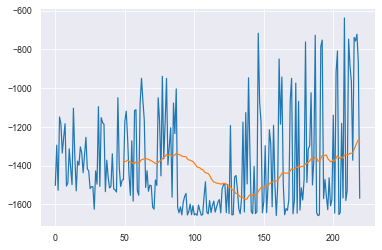

221 -1000.1289410326605 [1.e-05] 44200
222 -1239.9574723540131 [1.e-05] 44400
223 -1601.3346044700393 [1.e-05] 44600
224 -1179.0272593065886 [1.e-05] 44800
225 -381.98584282858207 [1.e-05] 45000
226 -499.32479224994665 [1.e-05] 45200
227 -745.5375638364669 [1.e-05] 45400
228 -743.9862864590963 [1.e-05] 45600
229 -728.0518787819669 [1.e-05] 45800
230 -738.4797089653414 [1.e-05] 46000
230 -1172.5647861545485


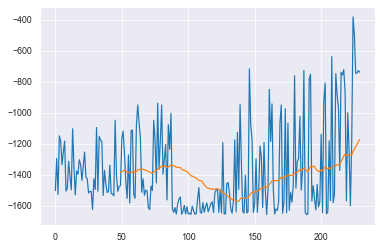

231 -809.0163236305071 [1.e-05] 46200
232 -897.58974488226 [1.e-05] 46400
233 -759.8227918276598 [1.e-05] 46600
234 -742.3117580097614 [1.e-05] 46800
235 -863.6836568058299 [1.e-05] 47000
236 -865.2736842281561 [1.e-05] 47200
237 -872.5762420283041 [1.e-05] 47400
238 -877.5202571451628 [1.e-05] 47600
239 -904.6303490563408 [1.e-05] 47800
240 -772.1322440157234 [1.e-05] 48000
240 -1084.1491411351237


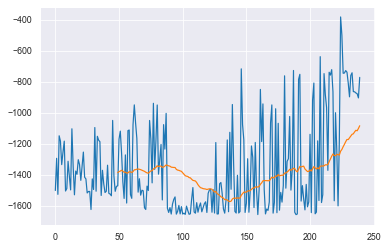

241 -990.7537727356332 [1.e-05] 48200
242 -1030.368654991709 [1.e-05] 48400
243 -1158.975636520265 [1.e-05] 48600
244 -1127.9437375433654 [1.e-05] 48800
245 -1096.5806187086214 [1.e-05] 49000
246 -1047.4081710347677 [1.e-05] 49200
247 -1165.357506839486 [1.e-05] 49400
248 -1027.152085216364 [1.e-05] 49600
249 -1080.628475918252 [1.e-05] 49800
250 -1045.4370034763595 [1.e-05] 50000
250 -1018.3155093903314


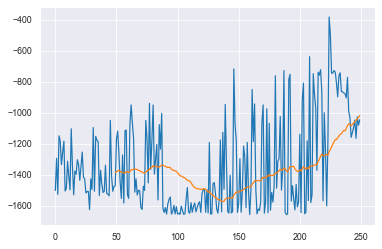

251 -1092.1924388118498 [1.e-05] 50200
252 -1029.2733487499859 [1.e-05] 50400
253 -1025.918297647513 [1.e-05] 50600
254 -1049.817953532645 [1.e-05] 50800
255 -1059.8236652881924 [1.e-05] 51000
256 -1025.9027576411675 [1.e-05] 51200
257 -1005.9612500063532 [1.e-05] 51400
258 -1104.204903117306 [1.e-05] 51600
259 -912.0296540302766 [1.e-05] 51800
260 -987.3698017541984 [1.e-05] 52000
260 -968.7345626071402


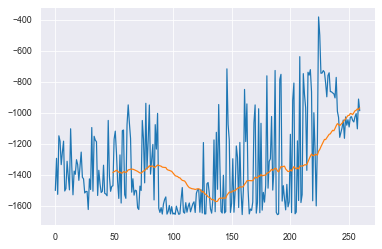

261 -1087.0825560294854 [1.e-05] 52200
262 -977.4337925536797 [1.e-05] 52400
263 -935.7054817600567 [1.e-05] 52600
264 -995.9206245208106 [1.e-05] 52800
265 -994.8187701494862 [1.e-05] 53000
266 -994.193686552962 [1.e-05] 53200
267 -1014.2165379090814 [1.e-05] 53400
268 -1016.7779497108191 [1.e-05] 53600
269 -994.5420321861573 [1.e-05] 53800
270 -903.7106527498938 [1.e-05] 54000
270 -963.997464392023


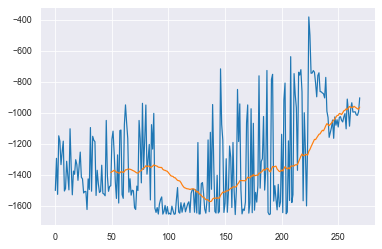

271 -801.238139367631 [1.e-05] 54200
272 -1022.0190350475872 [1.e-05] 54400
273 -902.3406981108709 [1.e-05] 54600
274 -840.1989418298101 [1.e-05] 54800
275 -896.1942078607153 [1.e-05] 55000
276 -915.6832686443475 [1.e-05] 55200
277 -884.3536614071187 [1.e-05] 55400
278 -956.6654209285025 [1.e-05] 55600
279 -756.3669144775505 [1.e-05] 55800
280 -792.410978924215 [1.e-05] 56000
280 -962.1906027182958


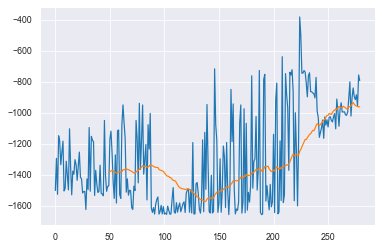

281 -874.9327588544993 [1.e-05] 56200
282 -848.757026352476 [1.e-05] 56400
283 -744.1908153530657 [1.e-05] 56600
284 -756.3437534747926 [1.e-05] 56800
285 -636.7006923462516 [1.e-05] 57000
286 -731.927450650928 [1.e-05] 57200
287 -632.1510123825428 [1.e-05] 57400
288 -686.392669324465 [1.e-05] 57600
289 -727.8252907220066 [1.e-05] 57800
290 -624.3132591674341 [1.e-05] 58000
290 -940.1701562582712


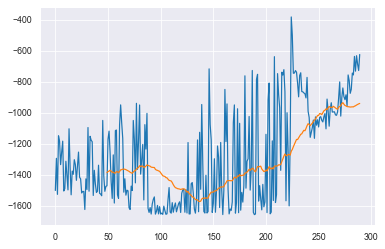

291 -631.3562474447151 [1.e-05] 58200
292 -695.9483260357435 [1.e-05] 58400
293 -736.9047352243541 [1.e-05] 58600
294 -741.7851675628333 [1.e-05] 58800
295 -522.2632882520757 [1.e-05] 59000
296 -128.55504457336008 [1.e-05] 59200
297 -506.5304421226805 [1.e-05] 59400
298 -507.1466761946986 [1.e-05] 59600
299 -371.2507868965237 [1.e-05] 59800
300 -509.0146831460825 [1.e-05] 60000
300 -831.7731509476358


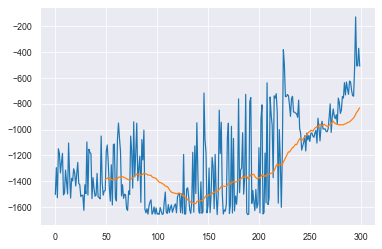

301 -498.69416360341927 [1.e-05] 60200
302 -256.50936550535005 [1.e-05] 60400
303 -373.78845419535605 [1.e-05] 60600
304 -623.3929404725806 [1.e-05] 60800
305 -352.67320701545884 [1.e-05] 61000
306 -365.584632683618 [1.e-05] 61200
307 -247.36597860838097 [1.e-05] 61400
308 -134.0214012554133 [1.e-05] 61600
309 -248.57849549639894 [1.e-05] 61800
310 -129.14262528149925 [1.e-05] 62000
310 -690.5182948183957


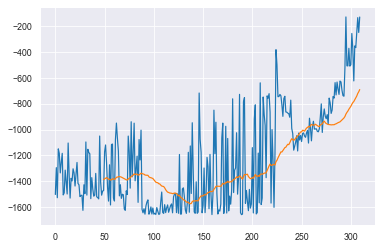

311 -359.4753089289986 [1.e-05] 62200
312 -133.05155765485307 [1.e-05] 62400
313 -116.82583951606134 [1.e-05] 62600
314 -1.1318350480263804 [1.e-05] 62800
315 -226.22131668313042 [1.e-05] 63000
316 -121.40592432301747 [1.e-05] 63200
317 -121.27980199589581 [1.e-05] 63400
318 -123.07491941492762 [1.e-05] 63600
319 -9.589198370326521 [1.e-05] 63800
320 -2.9441194044373966 [1.e-05] 64000
320 -516.5302495627406


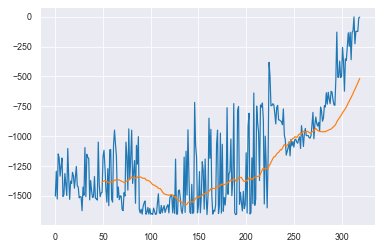

321 -120.61335377874413 [1.e-05] 64200
322 -135.32116849361486 [1.e-05] 64400
323 -142.5482581738298 [1.e-05] 64600
324 -126.23120395236558 [1.e-05] 64800
325 -128.96460798025942 [1.e-05] 65000
326 -242.94226338249234 [1.e-05] 65200
327 -137.20478040150323 [1.e-05] 65400
328 -362.8486696584576 [1.e-05] 65600
329 -123.13970130554044 [1.e-05] 65800
330 -250.4172304217804 [1.e-05] 66000
330 -376.5854489817453


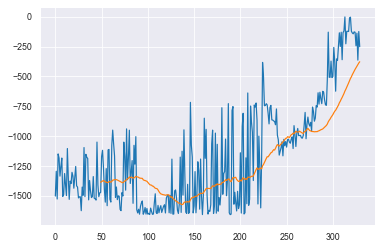

331 -868.6155232219678 [1.e-05] 66200
332 -857.054434766941 [1.e-05] 66400
333 -804.4976609718865 [1.e-05] 66600
334 -751.9851731568707 [1.e-05] 66800
335 -854.0595785351819 [1.e-05] 67000
336 -872.0694082483989 [1.e-05] 67200
337 -894.4175032052037 [1.e-05] 67400
338 -876.1247094449377 [1.e-05] 67600
339 -824.0034541175152 [1.e-05] 67800
340 -125.3133100352889 [1.e-05] 68000
340 -385.87756952326


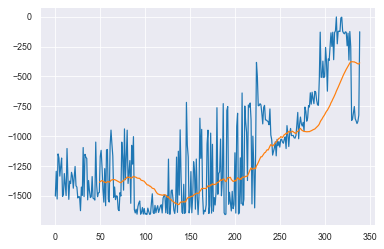

341 -234.80242193804833 [1.e-05] 68200
342 -13.63104600644803 [1.e-05] 68400
343 -128.9660891187435 [1.e-05] 68600
344 -129.17322552579432 [1.e-05] 68800
345 -252.52559884426375 [1.e-05] 69000
346 -119.98419621807932 [1.e-05] 69200
347 -121.10995578188441 [1.e-05] 69400
348 -119.79506101864476 [1.e-05] 69600
349 -125.40740491816717 [1.e-05] 69800
350 -118.86974271737388 [1.e-05] 70000
350 -306.1477564159475


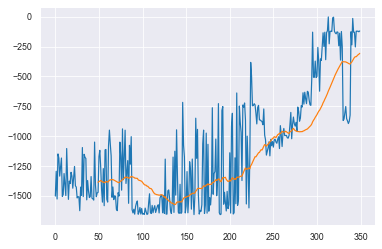

351 -0.9244927048460407 [1.e-05] 70200
352 -225.29499664490658 [1.e-05] 70400
353 -116.00787211269665 [1.e-05] 70600
354 -115.78815099204965 [1.e-05] 70800
355 -5.167476617699318 [1.e-05] 71000
356 -126.80157206030961 [1.e-05] 71200
357 -230.40345627711676 [1.e-05] 71400
358 -116.72582518383228 [1.e-05] 71600
359 -234.51694959640636 [1.e-05] 71800
360 -129.02014602691125 [1.e-05] 72000
360 -267.5657498979335


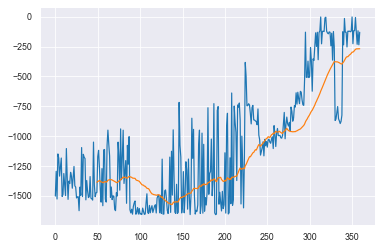

361 -238.33274961726624 [1.e-05] 72200
362 -122.67398416364448 [1.e-05] 72400
363 -129.77848990909143 [1.e-05] 72600
364 -128.27488047459488 [1.e-05] 72800
365 -6.262092272413865 [1.e-05] 73000
366 -124.87382894162259 [1.e-05] 73200
367 -127.38189319582602 [1.e-05] 73400
368 -125.51195727984094 [1.e-05] 73600
369 -4.743907396689537 [1.e-05] 73800
370 -118.65705477079062 [1.e-05] 74000
370 -265.79557023157565


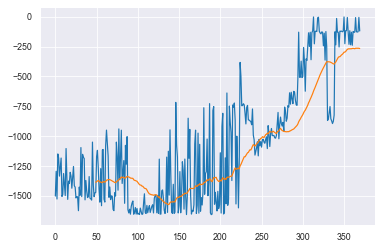

371 -123.64623200947156 [1.e-05] 74200
372 -230.22449969787797 [1.e-05] 74400
373 -4.147439626088931 [1.e-05] 74600
374 -282.8142971217765 [1.e-05] 74800
375 -230.53348338604812 [1.e-05] 75000
376 -121.23177392174313 [1.e-05] 75200
377 -121.76130361486004 [1.e-05] 75400
378 -132.6333849911393 [1.e-05] 75600
379 -130.8483500767369 [1.e-05] 75800
380 -250.38390388470947 [1.e-05] 76000
380 -262.9554388472129


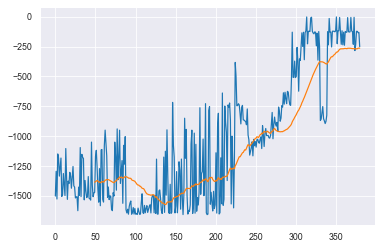

381 -11.37557273339079 [1.e-05] 76200
382 -125.87845906502503 [1.e-05] 76400
383 -257.34743208546405 [1.e-05] 76600
384 -339.82377305212447 [1.e-05] 76800
385 -128.18107365719067 [1.e-05] 77000
386 -127.92743578576399 [1.e-05] 77200
387 -239.72687735864082 [1.e-05] 77400
388 -129.23846489264352 [1.e-05] 77600
389 -127.61301249852723 [1.e-05] 77800
390 -122.82790199471219 [1.e-05] 78000
390 -140.59142379559876


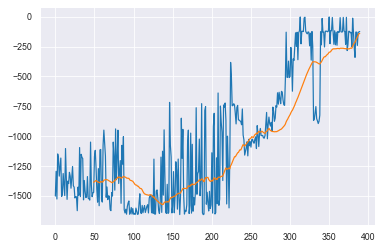

391 -235.47791228738106 [1.e-05] 78200
392 -132.46856445209315 [1.e-05] 78400
393 -134.2622879425757 [1.e-05] 78600
394 -255.48946487148257 [1.e-05] 78800
395 -130.66466163656452 [1.e-05] 79000
396 -129.8632822855579 [1.e-05] 79200
397 -252.26034931465776 [1.e-05] 79400
398 -132.28893721425018 [1.e-05] 79600
399 -130.1583997672042 [1.e-05] 79800
400 -128.79536845649832 [1.e-05] 80000
400 -146.54071351841512


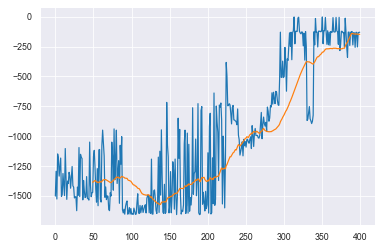

401 -127.32187665970577 [1.e-05] 80200
402 -357.18397268469414 [1.e-05] 80400
403 -240.76181061161338 [1.e-05] 80600
404 -14.818547848748144 [1.e-05] 80800
405 -134.9916320936243 [1.e-05] 81000
406 -15.718192163283494 [1.e-05] 81200
407 -132.7021558413565 [1.e-05] 81400
408 -17.773881309712866 [1.e-05] 81600
409 -16.199793753462565 [1.e-05] 81800
410 -134.35529847306384 [1.e-05] 82000
410 -144.3642379828649


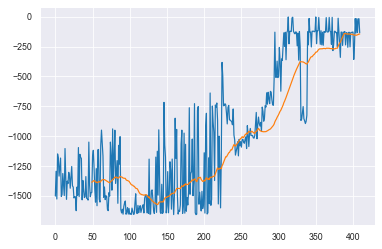

411 -249.8723710604825 [1.e-05] 82200
412 -241.59624921830593 [1.e-05] 82400
413 -249.66870814728256 [1.e-05] 82600
414 -134.0676882924563 [1.e-05] 82800
415 -136.95966434342228 [1.e-05] 83000
416 -16.589746528988595 [1.e-05] 83200
417 -137.9464236659538 [1.e-05] 83400
418 -246.34051291409043 [1.e-05] 83600
419 -126.33163031506881 [1.e-05] 83800
420 -133.25360569536127 [1.e-05] 84000
420 -155.28695322605753


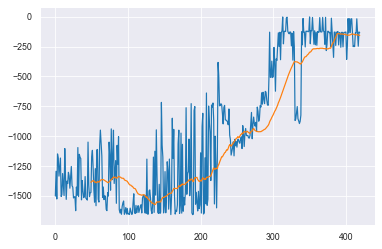

421 -136.99588668660596 [1.e-05] 84200
422 -374.1660500317904 [1.e-05] 84400
423 -135.16303393491097 [1.e-05] 84600
424 -135.36711448542857 [1.e-05] 84800
425 -117.47390239104897 [1.e-05] 85000
426 -115.52116707256914 [1.e-05] 85200
427 -1.00436084728592 [1.e-05] 85400
428 -1.5775585847104723 [1.e-05] 85600
429 -320.2752036416492 [1.e-05] 85800
430 -1.5147031494207261 [1.e-05] 86000
430 -149.50363947595693


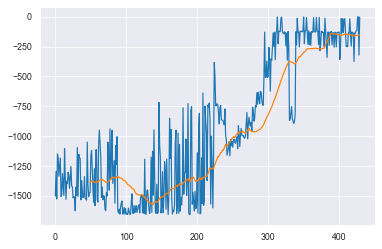

431 -115.61471106416239 [1.e-05] 86200
432 -120.74769858212335 [1.e-05] 86400
433 -118.72722725601263 [1.e-05] 86600
434 -124.82305098033993 [1.e-05] 86800
435 -243.0821111894981 [1.e-05] 87000
436 -243.60545764127397 [1.e-05] 87200
437 -128.38218146701405 [1.e-05] 87400
438 -339.3559991174238 [1.e-05] 87600
439 -126.44110920773454 [1.e-05] 87800
440 -8.849793823111241 [1.e-05] 88000
440 -148.69742622006115


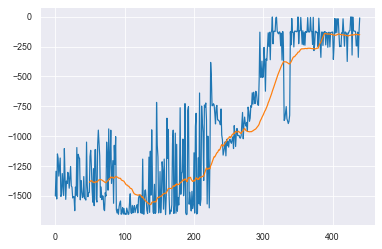

441 -127.26137734097036 [1.e-05] 88200
442 -271.08109472972535 [1.e-05] 88400
443 -123.13443790060359 [1.e-05] 88600
444 -120.88226896117061 [1.e-05] 88800
445 -119.53629100886289 [1.e-05] 89000
446 -249.7461054888517 [1.e-05] 89200
447 -248.78281500509132 [1.e-05] 89400
448 -126.78789019080905 [1.e-05] 89600
449 -125.71714947929722 [1.e-05] 89800
450 -120.26621162215886 [1.e-05] 90000
450 -148.12675449004666


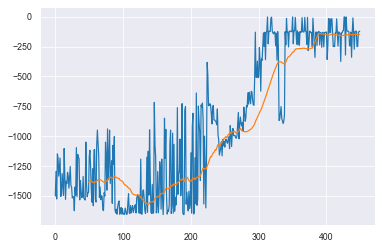

451 -118.51007195068074 [1.e-05] 90200
452 -127.89988841127412 [1.e-05] 90400
453 -120.97202375097649 [1.e-05] 90600
454 -127.83421261160225 [1.e-05] 90800
455 -119.78676870483632 [1.e-05] 91000
456 -2.1383706861649743 [1.e-05] 91200
457 -240.5112813767474 [1.e-05] 91400
458 -332.42583555103334 [1.e-05] 91600
459 -116.23253803960425 [1.e-05] 91800
460 -223.98309575830436 [1.e-05] 92000
460 -154.89609299808583


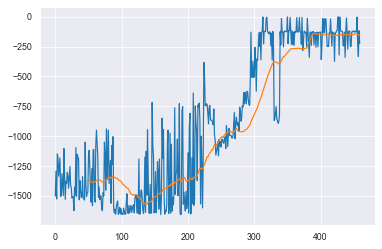

461 -121.81653627545684 [1.e-05] 92200
462 -120.4716309599477 [1.e-05] 92400
463 -121.12281682043435 [1.e-05] 92600
464 -240.80302934555556 [1.e-05] 92800
465 -117.02230712086259 [1.e-05] 93000
466 -121.53327932523256 [1.e-05] 93200
467 -1.7664581356416826 [1.e-05] 93400
468 -117.61491458735306 [1.e-05] 93600
469 -121.22989021962667 [1.e-05] 93800
470 -245.40182251744184 [1.e-05] 94000
470 -148.01921470060864


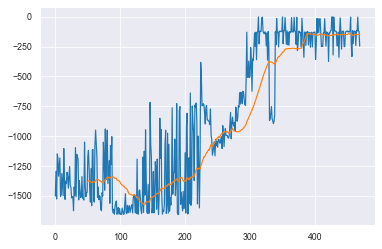

471 -119.43108253309347 [1.e-05] 94200
472 -356.3878618456234 [1.e-05] 94400
473 -243.50674404254542 [1.e-05] 94600
474 -238.80122460216467 [1.e-05] 94800
475 -126.59835338152322 [1.e-05] 95000
476 -224.55849077438899 [1.e-05] 95200
477 -241.03105907909827 [1.e-05] 95400
478 -122.97073190405897 [1.e-05] 95600
479 -117.27699042904315 [1.e-05] 95800
480 -124.30895155986506 [1.e-05] 96000
480 -159.53546488712834


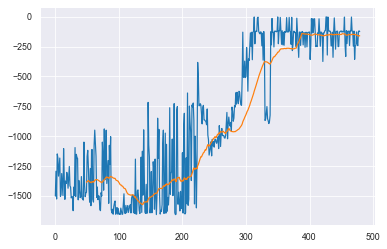

481 -1.5615255401696133 [1.e-05] 96200
482 -115.55851281754433 [1.e-05] 96400
483 -118.60718708453898 [1.e-05] 96600
484 -232.7215182012645 [1.e-05] 96800
485 -116.31364409435429 [1.e-05] 97000
486 -338.70991554529786 [1.e-05] 97200
487 -122.50012898085292 [1.e-05] 97400
488 -333.7830340696806 [1.e-05] 97600
489 -118.15352406539404 [1.e-05] 97800
490 -118.45906649890286 [1.e-05] 98000
490 -160.47023921851445


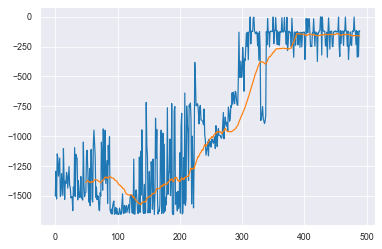

491 -300.90872998300307 [1.e-05] 98200
492 -227.42626875087976 [1.e-05] 98400
493 -119.65253775711675 [1.e-05] 98600
494 -116.2433160229903 [1.e-05] 98800
495 -245.42076170339445 [1.e-05] 99000
496 -124.30072934280437 [1.e-05] 99200
497 -124.90022422831481 [1.e-05] 99400
498 -116.28696891688362 [1.e-05] 99600
499 -118.0872842085047 [1.e-05] 99800
500 -240.66054748598503 [1.e-05] 100000
500 -162.48407375196118


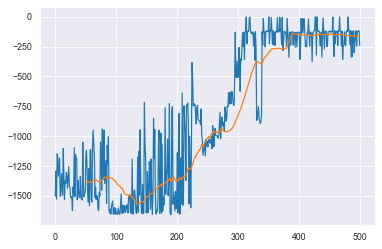

In [7]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_actor']=3e-3
agent_config['alpha_critic']=3e-3
agent_config['structure_actor']=[32,16]
agent_config['structure_critic']=[32,16]
agent_config['memory_size']=1e7
agent_config['batch_size']=32

agent_config['update_freq']=1
agent_config['sigma_decay']=0.999
agent_config['polyak']=0.99

agent_config['pure_explore_step']=10000
agent_config['start_learning_step']=5000

agent=DDPG(agent_config)

Iter=500
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    while not done:
        a = agent.get_actions(s.reshape(1,-1))[0]
        sp, r, done, info = env.step(a)
        agent.memorize(s,a,r,sp,done)
        agent.learn()
        s = sp
        G+=r
    G_log.append(G)
    print(len(G_log),G,agent.sigma,len(agent.memory))
    if (epoch+1)%10==0:
        print(len(G_log),np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show()  

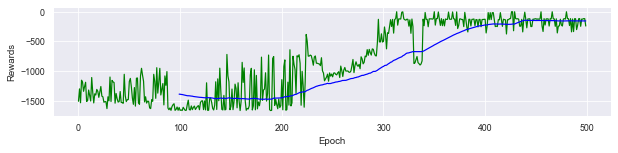

In [8]:
plt.figure(figsize=(10,2))
plt.plot(G_log,c="green")
plt.plot(pd.DataFrame(G_log).rolling(int(len(G_log)/5)).mean(),c="blue")
plt.xlabel("Epoch")
plt.ylabel("Rewards")
plt.show()

In [ ]:
env.close()    
s=env.reset()
env.render()
done=False
G=0
while not done:
    a = agent.actor.predict(s.reshape(1,-1))
    s, r, done, info = env.step(a[0])
    env.render() 
    G+=r
env.close()    
G